In [1]:
import os 
import cv2
import time 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as ans 
from tqdm import tqdm 
import shutil 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import Model
from tensorflow.keras import layers 
from tensorflow.keras.layers import *
import tensorflow_datasets as tfds
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import *
from datetime import datetime
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense, Input, UpSampling2D, Conv2DTranspose, Conv2D, add, Add,\
                    Lambda, Concatenate, AveragePooling2D, BatchNormalization, GlobalAveragePooling2D, \
                    Add, LayerNormalization, Activation, LeakyReLU
try:
    import tensorflow_addons as tfa 
except:
    !pip install tensorflow_addons
    import tensorflow_addons as tfa
    from tensorflow_addons.layers import InstanceNormalization

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
BATCH_SIZE = 8
HR_IMG_DIMS = (256, 256, 3)
LR_IMG_DIMS = (64, 64, 3)
NUM_RES_BLOCK = 8
REPEAT_COUNT = None
SCALE = 4 
NUM_FILTERS = 64
N_RES_BLOCKS = 16
RES_BLOCK_SCALIMG = None
DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255


In [3]:
div2k = tfds.image.Div2k(config='bicubic_x4')
div2k.download_and_prepare()

# train data
train_ds = div2k.as_dataset(split='train',as_supervised=True)  # 800 hr and 800 lr images
# validation data
val_ds = div2k.as_dataset(split='validation',as_supervised=True)  # 100 hr and 199 lr images

In [4]:
def random_crop(lr_img, hr_img, scale=4):
    ''' This function crops lr(64*64) and hr(256*256) images'''
    lr_crop_size = HR_IMG_DIMS[0] // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_width = tf.random.uniform(shape=(), maxval=LR_IMG_DIMS[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_height = tf.random.uniform(shape=(), maxval=LR_IMG_DIMS[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_width = lr_width * scale
    hr_height = lr_height * scale

    lr_img_cropped = lr_img[lr_height:lr_height + lr_crop_size, lr_width:lr_width + lr_crop_size]
    hr_img_cropped = hr_img[hr_height:hr_height + HR_IMG_DIMS[0], hr_width:hr_width + HR_IMG_DIMS[0]]

    return lr_img_cropped, hr_img_cropped

def random_flip(lr_img, hr_img):
    ''' This function will flip imag left_right randomly'''
    random = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(random < 0.5,lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))
        
def random_rotate(lr_img, hr_img):
    ''' This function will rotate image randomly to 90 degree'''
    rand = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rand), tf.image.rot90(hr_img, rand)

In [5]:
def data_augmentation(lr_img, hr_img):
    lr_img = tf.cast(lr_img, tf.float32)
    hr_img = tf.cast(hr_img, tf.float32)
    lr_img, hr_img = random_crop(lr_img, hr_img)
    lr_img, hr_img = random_rotate(lr_img, hr_img)
    lr_img, hr_img = random_flip(lr_img, hr_img)
    
    return lr_img, hr_img

In [23]:
train_ds = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None))>

In [6]:
val_ds = val_ds.repeat(1)
val_ds = val_ds.batch(1)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
val_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None))>

(64, 64, 3)


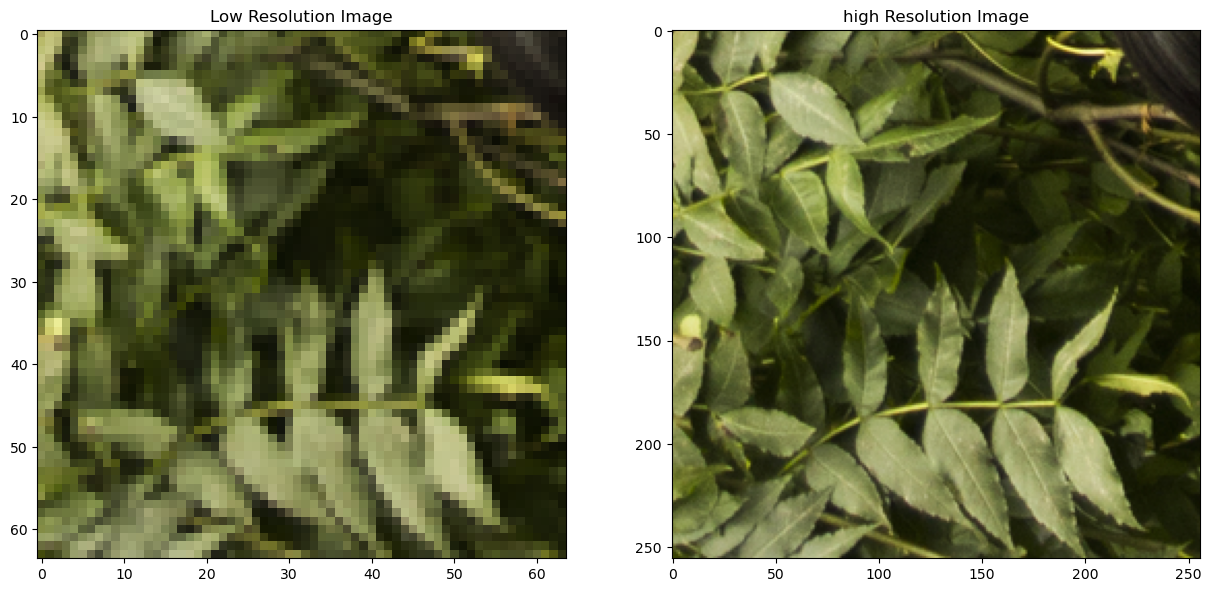

In [8]:
sample_data = next(iter(train_ds))
lr_sample_image = sample_data[0][0]
hr_sample_image = sample_data[1][0]
print(lr_sample_image.shape)

lr_sample_image = tf.reshape(lr_sample_image, (64, 64, 3))
hr_sample_image = tf.reshape(hr_sample_image, (256, 256, 3))

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(lr_sample_image/ 255.0)
plt.title("Low Resolution Image")

plt.subplot(1, 2, 2)
plt.imshow(hr_sample_image/ 255.0)
plt.title("high Resolution Image")

del sample_data

In [13]:
def residual_block(x_input, num_filters, scaling):
    '''This function Implementes Proposed ResBlock Architecture as per EDSR paper'''
    x = Conv2D(num_filters, 3, padding='same', activation='relu')(x_input)
    x = Conv2D(num_filters, 3, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_input, x])
    return x

In [14]:
def upsampling_block(apply_bn=False, apply_dropout=False,
                     filters=256, kernel_size=(3, 3), upsamling_size=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(Conv2D(filters, kernel_size, padding="same"))
    result.add(UpSampling2D(size = upsamling_size))
    
    if apply_bn:
        result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.PReLU())

    return result

In [15]:
def upsampling(x, scale, num_filters):
    '''This function upsampling as mentioned in EDSR paper'''
    def upsample(x, factor, **kwargs):
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return Lambda(shuffle_pixels(scale=factor))(x)

    if scale == 2:
        x = upsample(x, 2)
    elif scale == 3:
        x = upsample(x, 3)
    elif scale == 4:
        x = upsample(x, 2)
        x = upsample(x, 2)

    return x

In [16]:
def normalize(x,rgb_mean=DIV2K_RGB_MEAN):
    '''This function will normalize image by substracting RGB mean from image'''
    return (x - rgb_mean) / 127.5

def denormalize(x,rgb_mean=DIV2K_RGB_MEAN):
    ''' This function will denormalize image by adding back rgb_mean'''
    return (x * 127.5 )+ rgb_mean

def shuffle_pixels(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

In [17]:
def get_edsr():
    x_input = Input(shape=(None, None, 3))
    # Normalize input with DIV2K_RGB_MEAN
    x = Lambda(normalize)(x_input)
    
    # assign value of x to x_res block for further operations
    x = x_res_block = Conv2D(NUM_FILTERS, 3, padding='same')(x)

    # Goes in number of res block
    for i in range(N_RES_BLOCKS):
        x_res_block =  residual_block(x_res_block, NUM_FILTERS, RES_BLOCK_SCALIMG)
    # convolution
    x_res_block = Conv2D(NUM_FILTERS, 3, padding='same')(x_res_block)
    # add res_block output and original normalizwd input
    x = Add()([x, x_res_block])

    # upsampling
    x = upsampling(x, SCALE, NUM_FILTERS)
    x = Conv2D(3, 3, padding='same')(x)
    
    # denormalize to get back original form
    x_output = Lambda(denormalize)(x)
    return Model(x_input, x_output)

In [14]:
edsr = get_edsr()
edsr.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 lambda (Lambda)                (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   1792        ['lambda[0][0]']                 
                                64)                                                           

In [9]:
class EDSRTrainer(keras.models.Model): 
    def __init__(self, edsr_model):
        super(EDSRTrainer, self).__init__()
        self.edsr_loss_tracker = tf.keras.metrics.Mean()
        
        self.edsr_model = edsr_model
        
        self.summary_writer = tf.summary.create_file_writer(
        "logs/" + "fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    @property
    def metrics(self):
        pass 
    
    def call(self, inputs):
        sr = self.edsr_model(inputs)
        return sr

    def train_step(self, inputs):
        lr_img, hr_img = inputs
        
        with tf.GradientTape(persistent=True) as tape:
            # generate the super resolution image
            hr_edsr_img = self.edsr_model(lr_img, training=True)
            
            # loss
            loss_val = self.compiled_loss(hr_img, hr_edsr_img)

        # Params
        params = self.edsr_model.trainable_weights
        
        # grads
        grads = tape.gradient(loss_val, params)
        
        # Back Propagate
        self.optimizer.apply_gradients(zip(grads, params))
        
        # loss tracker
        self.edsr_loss_tracker.update_state(loss_val)

        #with self.summary_writer.as_default():
        #tf.summary.scalar('gen_total_loss', total_gen_loss, step=step//1000)
        #tf.summary.scalar('gen_gan_loss', gan_loss, step=step//1000)
        #tf.summary.scalar('gen_l1_loss', l1_loss, step=step//1000)
        #tf.summary.scalar('disc_loss', total_disc_loss, step=step//1000)
        return {
                "loss": self.edsr_loss_tracker.result(), 
               }
    
    def test_step(self, val_ds):
        psnr_val = self.get_psnr(val_ds)
        ssim_val = self.get_ssim(val_ds)
        
        return psnr_val, ssim_val
    
    def compute_loss(self, hr, sr):
        loss_func = tf.keras.metrics.MeanAbsoluteError()
        loss = loss_func(hr, sr)
        return loss
    
    def get_psnr(self, ds):
        psnr_values = []
        for lr, hr in ds:
            # convert dtype to float32
            lr = tf.cast(lr, tf.float32)
            # get sr image from model
            sr = self.edsr_model(lr)
            # clip values to 0,255
            sr = tf.clip_by_value(sr, 0, 255)
            # round up values
            sr = tf.round(sr)
            # change dtype to unint8
            sr = tf.cast(sr, tf.uint8)
            # get psnr value
            psnr_value = tf.image.psnr(hr, sr, max_val=255)[0]
            # append psnr value
            psnr_values.append(psnr_value)
        return tf.reduce_mean(psnr_values)
    
    def get_ssim(self, ds):
        ssim_values = []
        for lr,hr in ds:
            # convert dtype to float32
            lr = tf.cast(lr, tf.float32)
            # get sr image from model
            sr = self.edsr_model(lr)
            # clip values to 0,255
            sr = tf.clip_by_value(sr, 0, 255)
            # round up values
            sr = tf.round(sr)
            # change dtype to unint8
            sr = tf.cast(sr, tf.uint8)
            # get ssim value
            ssim_value = tf.image.ssim(hr, sr, max_val=255).numpy()[0]
            # append ssim value
            ssim_values.append(ssim_value)
        return tf.reduce_mean(ssim_values)
    
    def get_mos(self, ds):
        pass 

In [10]:
edsr_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [18]:
edsr_model = get_edsr()

In [19]:
model = EDSRTrainer(edsr_model)
model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=edsr_optimizer)

In [20]:
ckpt = tf.train.Checkpoint(step=tf.Variable(1),
                           edsr_optimizer=edsr_optimizer,
                           model=model,
                           psnr=tf.Variable(-1.0),
                           ssim = tf.Variable(-1.0)
                          )
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=3)

In [24]:
def train(model, train_ds, test_ds, epochs, manager):
    loss_list = []
    
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
    
    for epoch in range(epochs):
        for step, train_data_batch in tqdm(enumerate(train_ds), total=len(train_ds)):
            result = model.train_step(train_data_batch)
            loss = result.get("loss")
            
            ckpt.step.assign_add(1)
            
        # test step
        psnr_val, ssim_val = model.test_step(test_ds)
        
        if psnr_val > ckpt.psnr: 
            save_path = manager.save()
            ckpt.psnr = psnr_val
            print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
        
        loss_list.append(loss)
        
        print(f"Epochs: {epoch}, loss: {loss}")
    return model

In [25]:
train(model, train_ds, val_ds.take(10), 1, manager)

Restored from ./tf_ckpts/ckpt-59


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


Saved checkpoint for step 7701: ./tf_ckpts/ckpt-60
Epochs: 0, loss: 5.636152267456055


In [26]:
model.edsr_model.save('trained_edsr_model_60.h5')
trained_model = tf.keras.models.load_model("trained_edsr_model_60.h5")

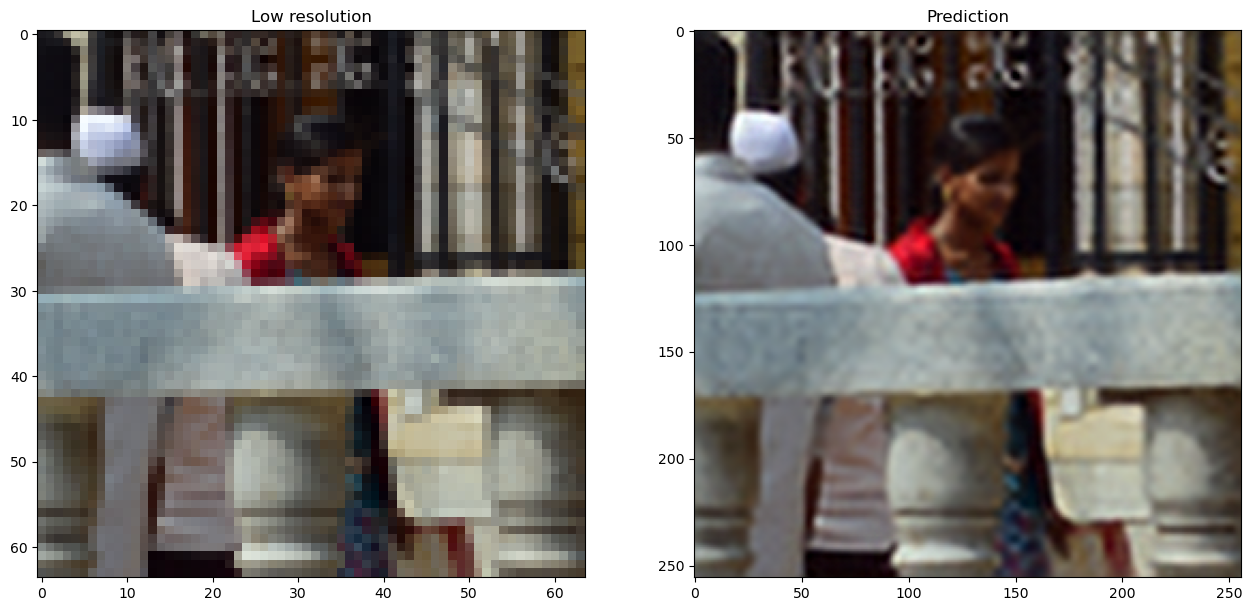

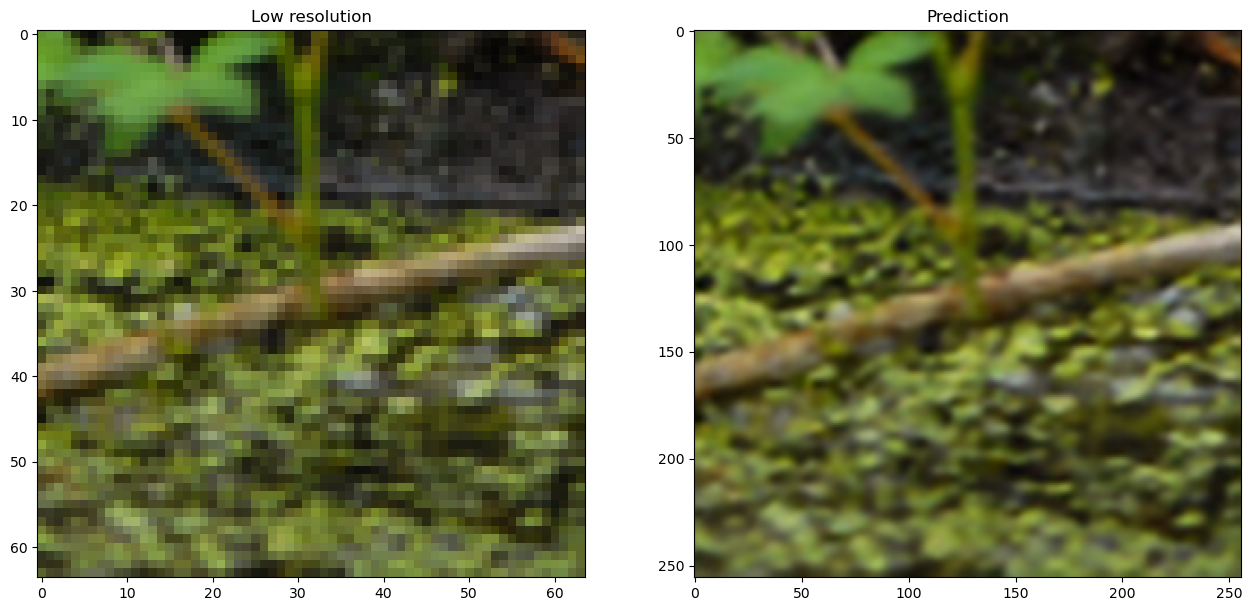

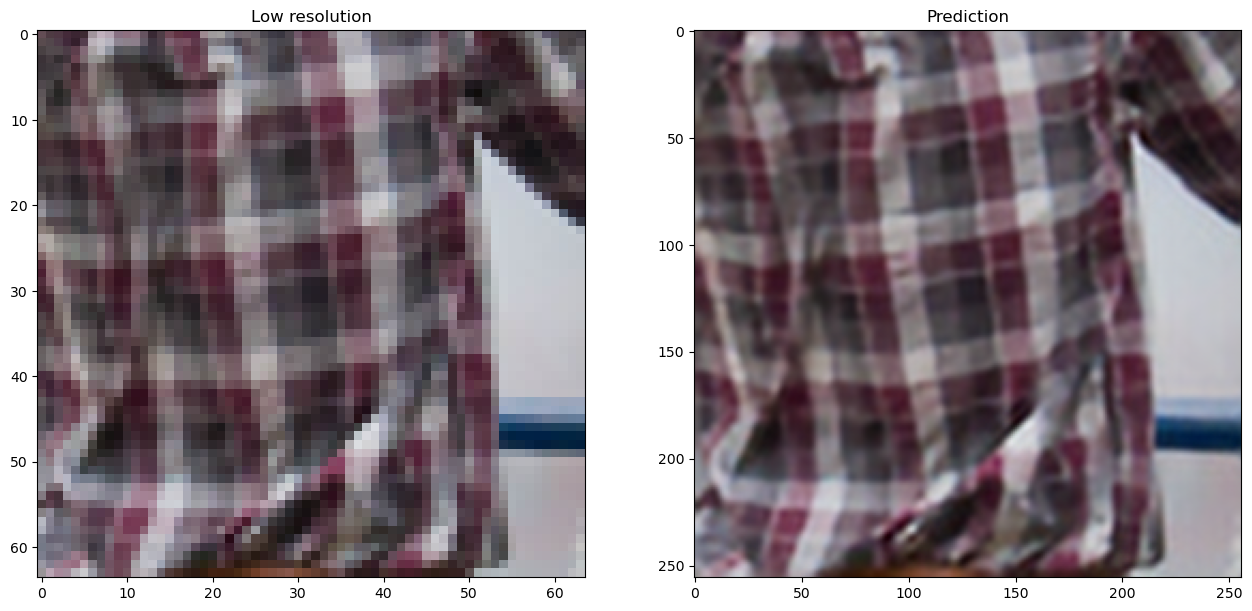

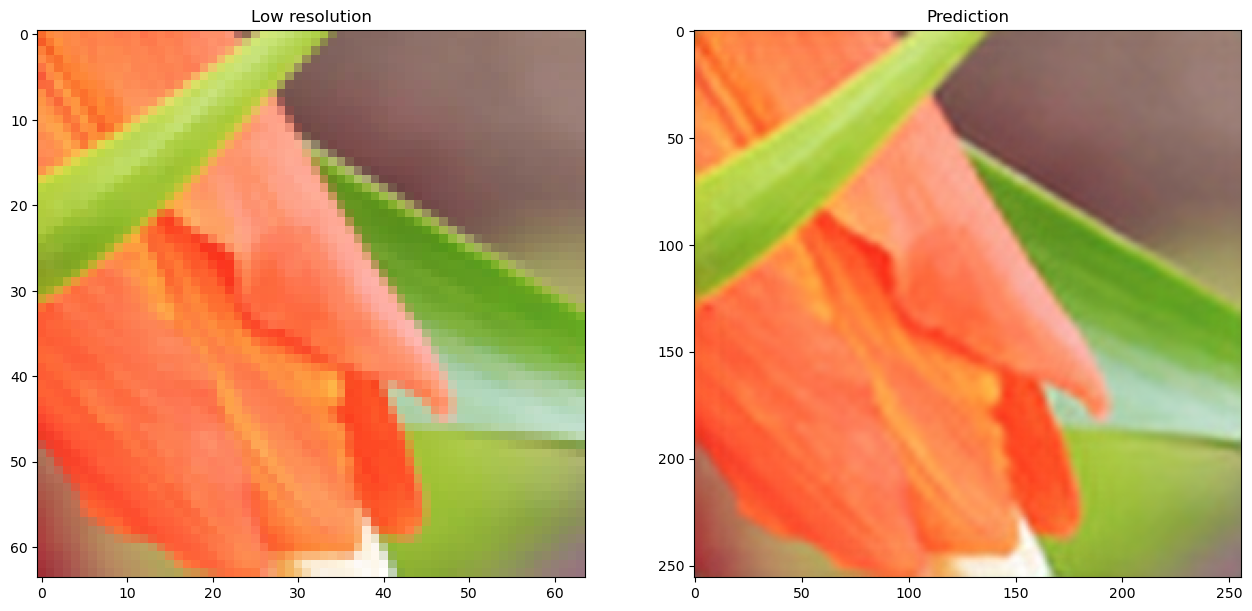

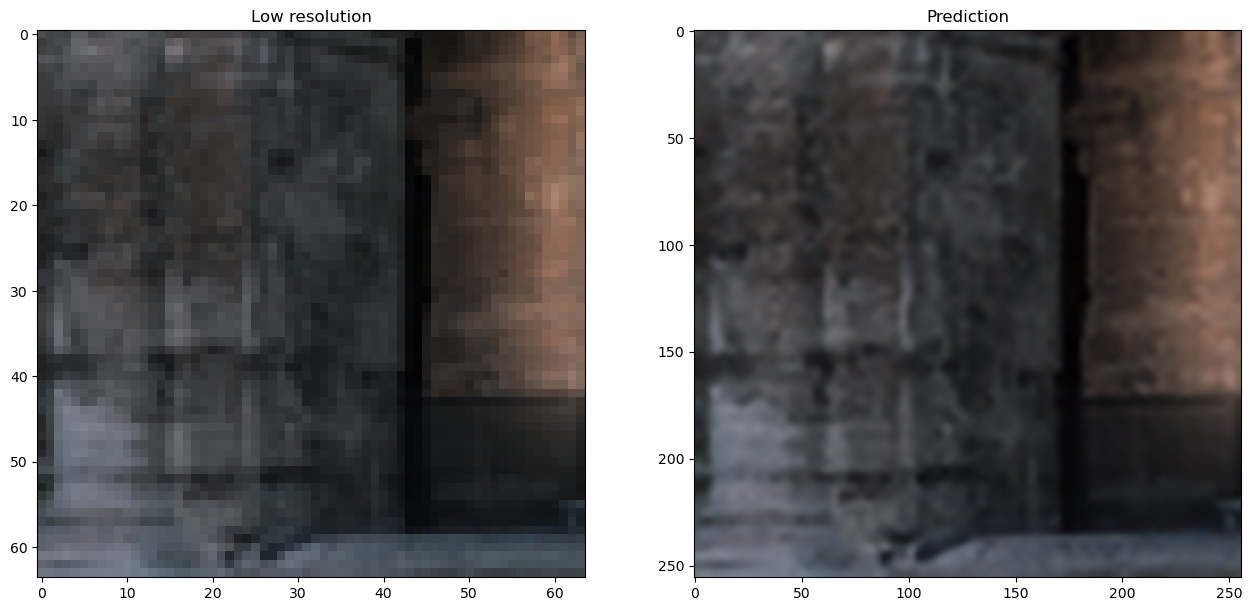

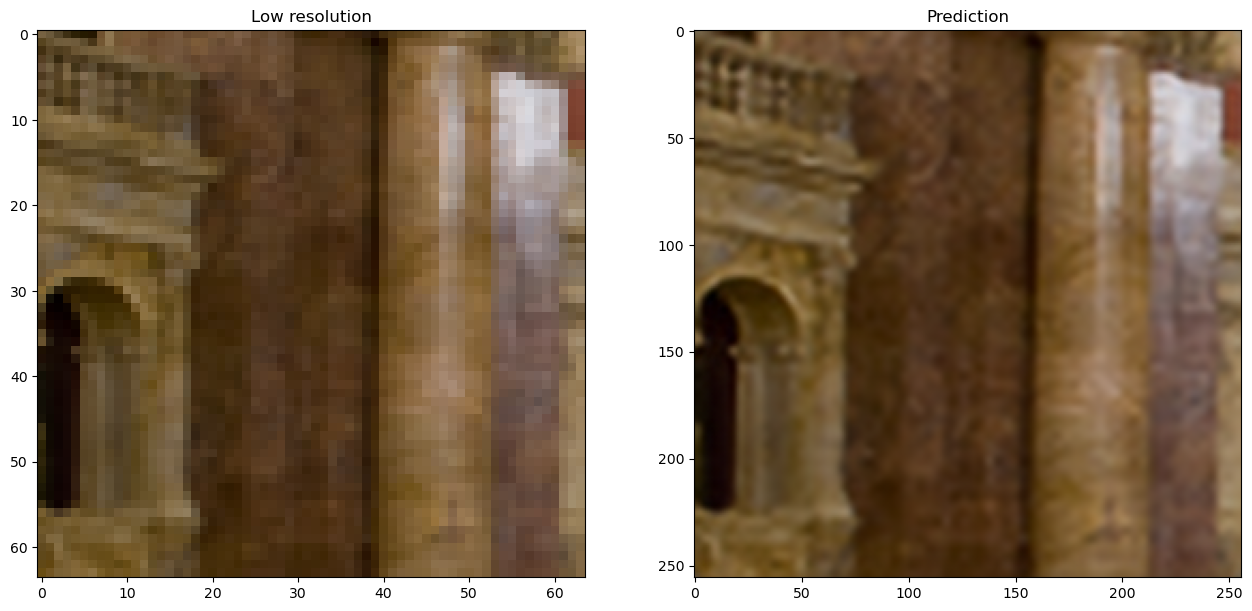

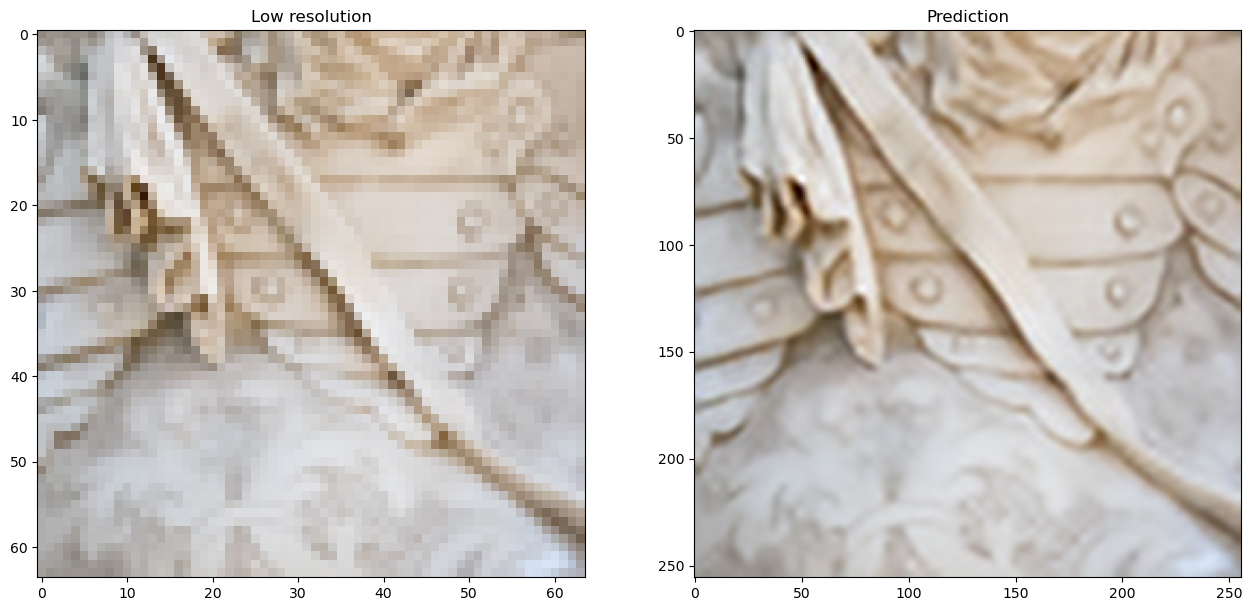

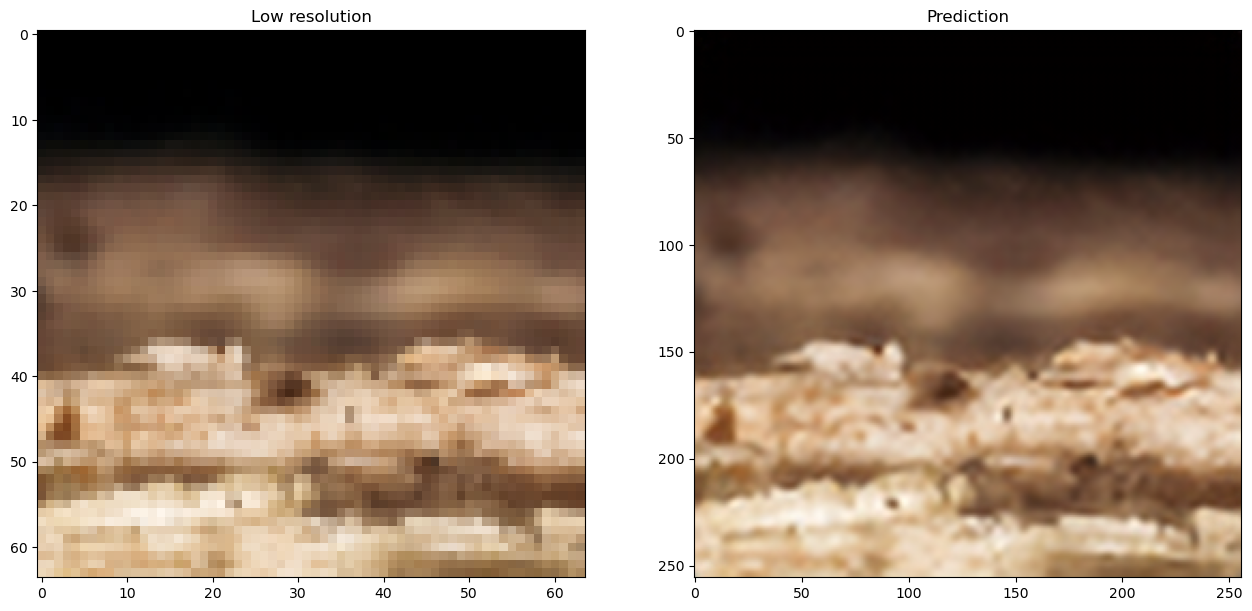

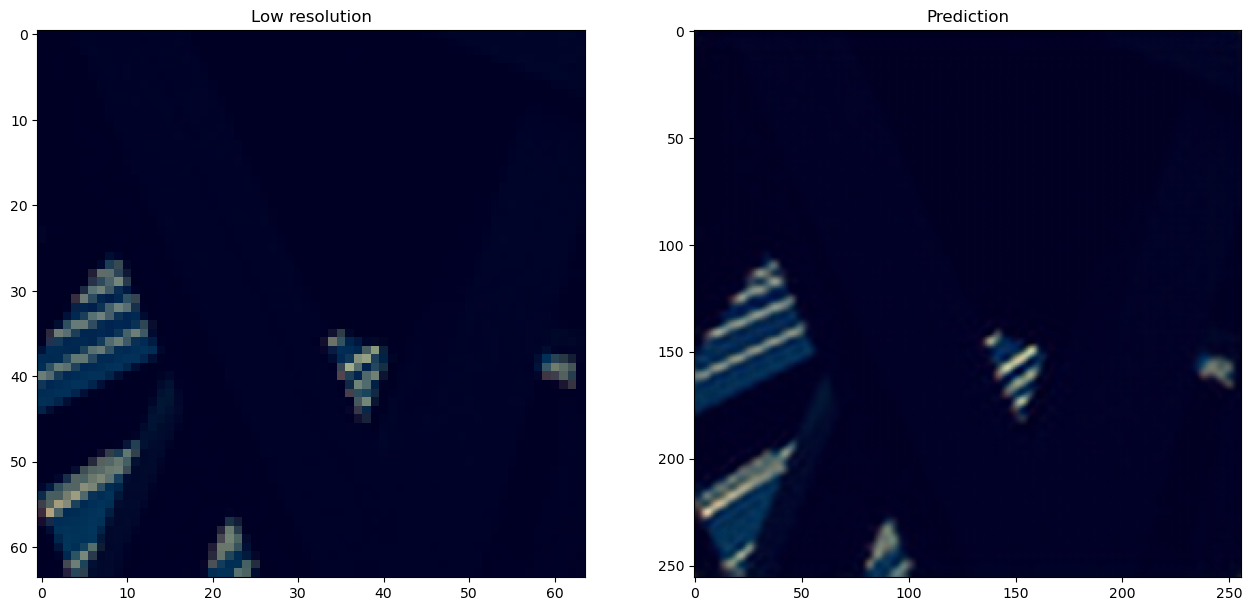

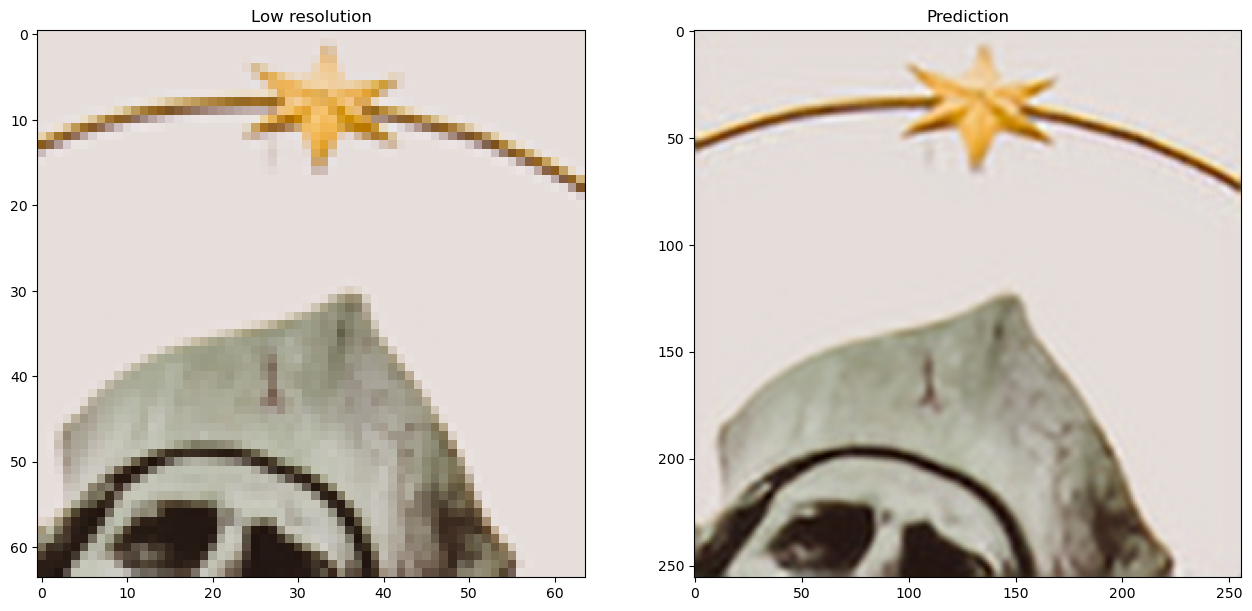

In [29]:
def plot_results(lowres, preds, highres):
    """
    Displays low resolution image and super resolution image
    """
    plt.figure(figsize=(24, 14))
    plt.subplot(132), plt.imshow(lowres), plt.title("Low resolution")
  #  plt.subplot(132), plt.imshow(highres), plt.title("Hight resolution")
    plt.subplot(133), plt.imshow(preds/255.0), plt.title("Prediction")
    plt.show()

for lowres, highres in val_ds.take(10):
    lowres = lowres[0]
    highres = highres[0]

    lowres = tf.image.random_crop(lowres, (64, 64, 3))
    lowres = tf.expand_dims(lowres, 0)
    preds = trained_model(lowres)
    preds = preds[0]
    preds = tf.cast(preds, tf.float32)
    lowres = lowres[0]
    
    plot_results(lowres, preds, highres)